## Realizando uma limpeza de Outliers dos dados

Ao realizarmos as análises sem tirar aberrações -como por exemplo 50 gols em uma partida- os resultados são afetados negativamente. Para evitarmos isso, vamos utilizar o método de Intervalo Interquartil, que busca valores de alto desvio padrão, ou seja, valores que destoam da média de todos. Para isso precisamos definir intervalos inferiores Q1 e superiores Q3: IQR = Q3 - Q1. Também podemos fazer análises individuais para cada coluna, por exemplo, posse de bola que somadas passem de 100% indicam incongruência.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega o CSV
df_original = pd.read_csv('entrada.csv')
df = df_original.copy()

# Cabeçalho da tabela
print(f"{'Coluna':<25} {'Qtd Outliers':<15} {'Média Outliers':<20} {'% Removido':<12}")
print('-' * 72)

# Define colunas com tratamento especial
colunas_gols = ['Gols 1', 'Gols 2']
colunas_faltas = ['Faltas 1', 'Faltas 2']
colunas_subs = ['Substituições 1', 'Substituições 2']
colunas_posse = ['Posse 1(%)', 'Posse 2(%)']
colunas_cartoes_amarelos = ['Cartões amarelos 1', 'Cartões amarelos 2']
colunas_cartoes_vermelhos = ['Cartões vermelhos 1', 'Cartões vermelhos 2']

# Função padrão com IQR ajustado
def identificar_outliers_iqr(coluna):
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 2.7 * IQR
    limite_superior = Q3 + 2.7 * IQR
    return coluna[(coluna < limite_inferior) | (coluna > limite_superior)]

# Tratamento especial
def identificar_outliers_personalizado(coluna, nome):
    if nome in colunas_gols:
        return coluna[coluna >= 10]
    elif nome in colunas_faltas:
        return coluna[coluna >= 40]
    elif nome in colunas_subs:
        return coluna[coluna >= 6]
    elif nome in colunas_posse:
        return coluna[(coluna > 100.5) | (coluna < 0)]
    elif nome in colunas_cartoes_amarelos:
        return coluna[coluna > 6]
    elif nome in colunas_cartoes_vermelhos:
        return coluna[coluna > 3]
    else:
        return identificar_outliers_iqr(coluna)

# Itera por cada coluna numérica
for coluna in df.select_dtypes(include=['int64', 'float64']).columns:
    serie = df[coluna]
    outliers = identificar_outliers_personalizado(serie, coluna)
    qtd_outliers = len(outliers)
    media_outliers = outliers.mean() if not outliers.empty else 0
    perc_outliers = (qtd_outliers / len(df_original)) * 100

    # Remove os outliers
    df = df[~df[coluna].isin(outliers)]

    # Imprime linha da tabela
    print(f"{coluna:<25} {qtd_outliers:<15} {media_outliers:<20.2f} {perc_outliers:<.2f}%")

# Salva o CSV limpo
df.to_csv('saida_sem_outliers.csv', index=False)
print("\nArquivo limpo salvo como 'saida_sem_outliers.csv'")


Coluna                    Qtd Outliers    Média Outliers       % Removido  
------------------------------------------------------------------------
Chutes a gol 1            80              17.14                0.29%
Chutes a gol 2            43              16.88                0.16%
Impedimentos 1            118             9.86                 0.43%
Impedimentos 2            76              9.71                 0.27%
Escanteios 1              24              18.71                0.09%
Escanteios 2              45              15.96                0.16%
Chutes fora 1             46              20.43                0.17%
Chutes fora 2             27              46.15                0.10%
Faltas 1                  1               46.00                0.00%
Faltas 2                  2               105.00               0.01%
Cartões amarelos 1        58              7.33                 0.21%
Cartões amarelos 2        114             7.26                 0.41%
Cartões vermelhos 1    

### Oque conseguimos de destaque?

Por meio dessa análise limpamos incongruências bizarras como 748 chutes fora!

### Comparação de resultados

Vamos comparar os resultados de congruência de "Chutes fora 2" antes e depois da limpeza apenas para ter uma demonstração de quão destrutivo pode ser a presença de um único ponto fora da curva!

Poderíamos fazer para cada uma das colunas, mas por efeito de simplicidade vamos nos ater a mostrar esse caso, mas semelhante acontece com outros.

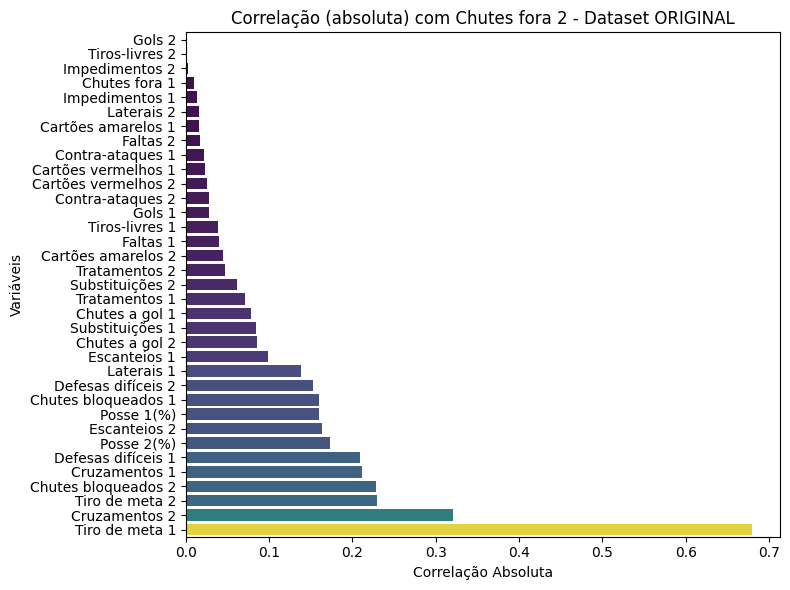

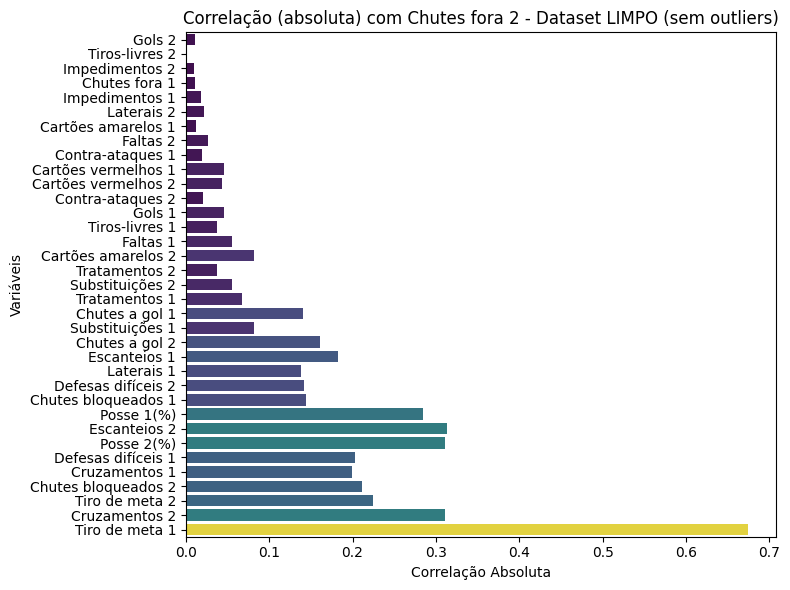

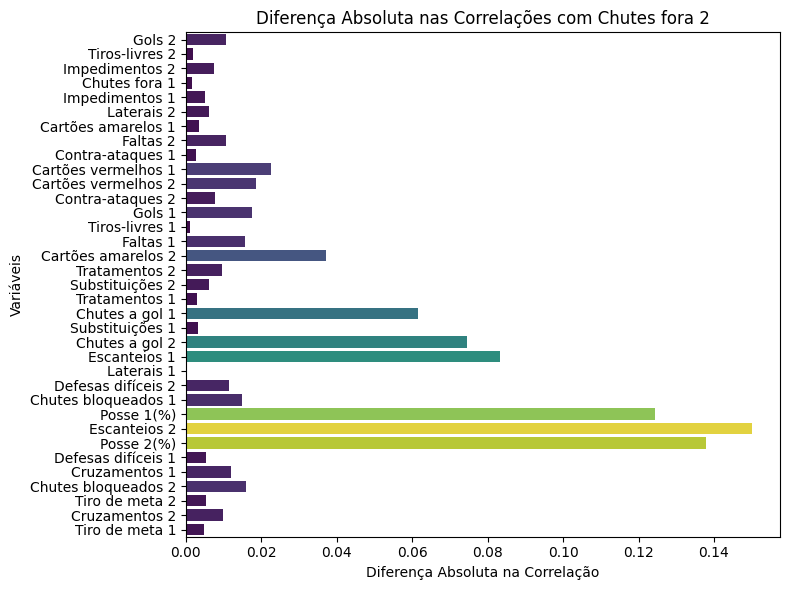

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lê os dados
df_original = pd.read_csv('entrada.csv')
df_limpo = pd.read_csv('saida_sem_outliers.csv')

# Remove colunas sem variância
df_valido_original = df_original.loc[:, df_original.nunique() > 1]
df_valido_limpo = df_limpo.loc[:, df_limpo.nunique() > 1]

# Filtra apenas colunas numéricas
df_numerico_original = df_valido_original.select_dtypes(include='number')
df_numerico_limpo = df_valido_limpo.select_dtypes(include='number')

# Calcula correlação
correlacao_original = df_numerico_original.corr(numeric_only=True)
correlacao_limpo = df_numerico_limpo.corr(numeric_only=True)

# Variável alvo
variavel_alvo = 'Chutes fora 2'

# Filtra correlações com a variável alvo (exceto ela mesma)
correlacoes_original = correlacao_original[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()
correlacoes_limpo = correlacao_limpo[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()

# Interseção de variáveis comuns
variaveis_comuns = correlacoes_original.index.intersection(correlacoes_limpo.index)
correlacoes_original = correlacoes_original.loc[variaveis_comuns]
correlacoes_limpo = correlacoes_limpo.loc[variaveis_comuns]

# Ordena conforme o dataset original (ordem base)
ordem_variaveis = correlacoes_original.sort_values().index

# Reordena os dados conforme o gráfico 1
correlacoes_original_ordenadas = correlacoes_original.loc[ordem_variaveis]
correlacoes_limpo_ordenadas = correlacoes_limpo.loc[ordem_variaveis]
diferencas_ordenadas = (correlacoes_limpo_ordenadas - correlacoes_original_ordenadas).abs()

# Função auxiliar para gerar cores com gradiente horizontal
def gerar_cores(valores, cmap_name='coolwarm'):
    norm = plt.Normalize(valores.min(), valores.max())
    cmap = plt.get_cmap(cmap_name)
    return [cmap(norm(v)) for v in valores]

# --- Plot 1: Dataset original ---
plt.figure(figsize=(8, 6))
cores1 = gerar_cores(correlacoes_original_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_original_ordenadas.values,
            y=correlacoes_original_ordenadas.index,
            palette=cores1)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset ORIGINAL')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 2: Dataset limpo ---
plt.figure(figsize=(8, 6))
cores2 = gerar_cores(correlacoes_limpo_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_limpo_ordenadas.values,
            y=correlacoes_limpo_ordenadas.index,
            palette=cores2)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset LIMPO (sem outliers)')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 3: Diferença absoluta ---
plt.figure(figsize=(8, 6))
cores3 = gerar_cores(diferencas_ordenadas.values, cmap_name='viridis')
sns.barplot(x=diferencas_ordenadas.values,
            y=diferencas_ordenadas.index,
            palette=cores3)
plt.title(f'Diferença Absoluta nas Correlações com {variavel_alvo}')
plt.xlabel('Diferença Absoluta na Correlação')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

### Vamos ver as correlações em relação ao Gols

Sabendo se a correlação é forte nos ajuda a decidir se desconsideramos a coluna ou tentaremos outras abordagens.

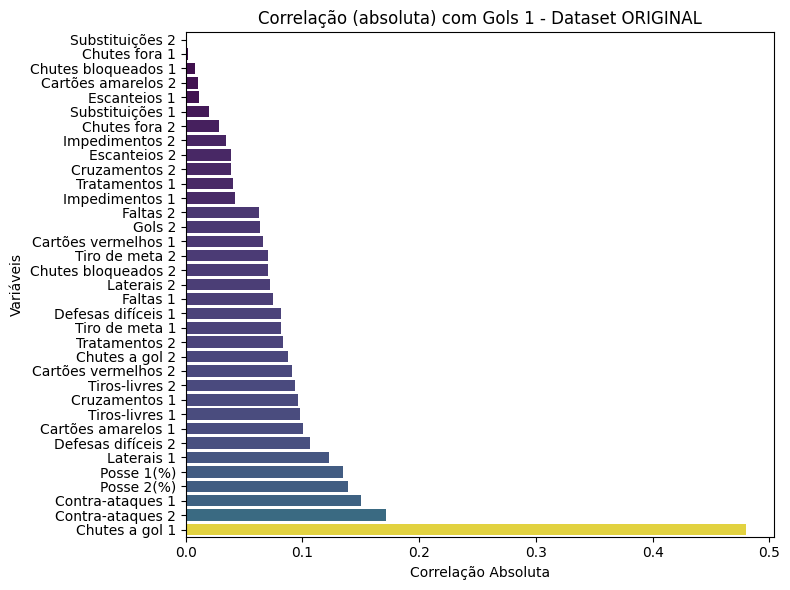

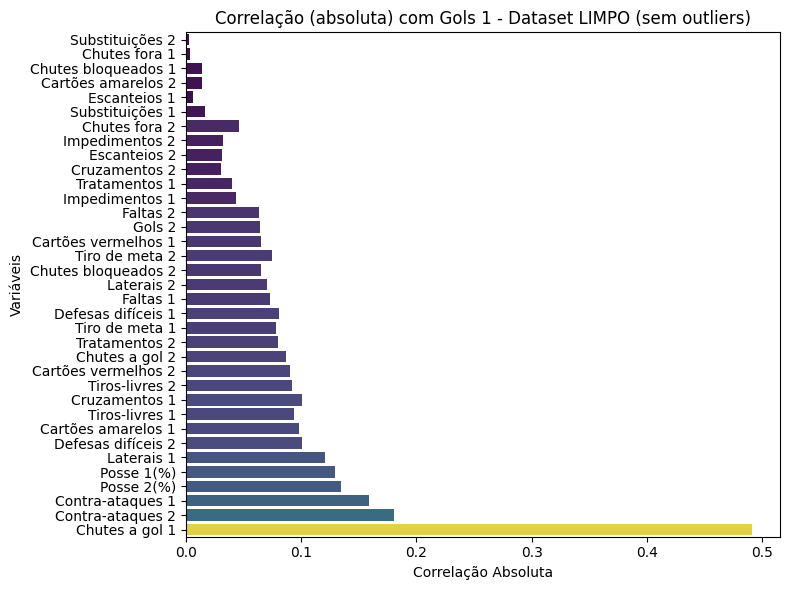

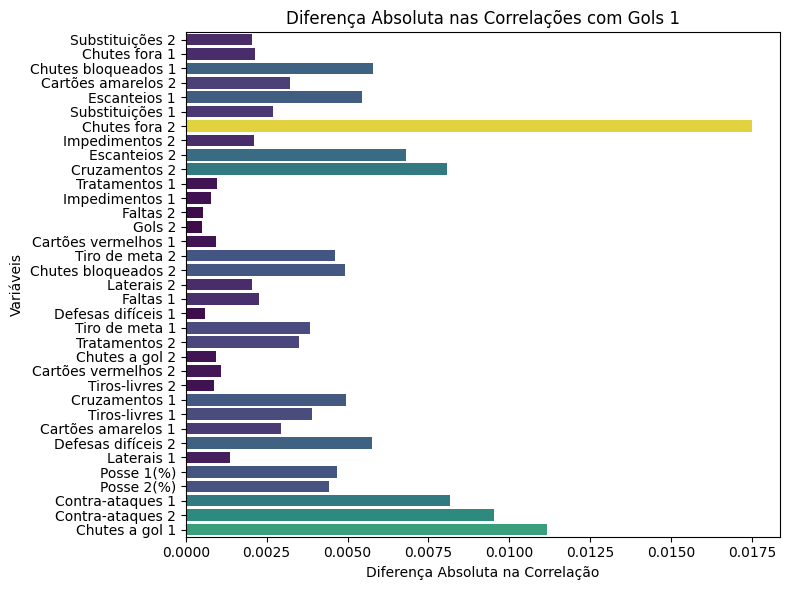

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lê os dados
df_original = pd.read_csv('entrada.csv')
df_limpo = pd.read_csv('saida_sem_outliers.csv')

# Remove colunas sem variância
df_valido_original = df_original.loc[:, df_original.nunique() > 1]
df_valido_limpo = df_limpo.loc[:, df_limpo.nunique() > 1]

# Filtra apenas colunas numéricas
df_numerico_original = df_valido_original.select_dtypes(include='number')
df_numerico_limpo = df_valido_limpo.select_dtypes(include='number')

# Calcula correlação
correlacao_original = df_numerico_original.corr(numeric_only=True)
correlacao_limpo = df_numerico_limpo.corr(numeric_only=True)

# Variável alvo
variavel_alvo = 'Gols 1'

# Filtra correlações com a variável alvo (exceto ela mesma)
correlacoes_original = correlacao_original[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()
correlacoes_limpo = correlacao_limpo[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()

# Interseção de variáveis comuns
variaveis_comuns = correlacoes_original.index.intersection(correlacoes_limpo.index)
correlacoes_original = correlacoes_original.loc[variaveis_comuns]
correlacoes_limpo = correlacoes_limpo.loc[variaveis_comuns]

# Ordena conforme o dataset original (ordem base)
ordem_variaveis = correlacoes_original.sort_values().index

# Reordena os dados conforme o gráfico 1
correlacoes_original_ordenadas = correlacoes_original.loc[ordem_variaveis]
correlacoes_limpo_ordenadas = correlacoes_limpo.loc[ordem_variaveis]
diferencas_ordenadas = (correlacoes_limpo_ordenadas - correlacoes_original_ordenadas).abs()

# Função auxiliar para gerar cores com gradiente horizontal
def gerar_cores(valores, cmap_name='coolwarm'):
    norm = plt.Normalize(valores.min(), valores.max())
    cmap = plt.get_cmap(cmap_name)
    return [cmap(norm(v)) for v in valores]

# --- Plot 1: Dataset original ---
plt.figure(figsize=(8, 6))
cores1 = gerar_cores(correlacoes_original_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_original_ordenadas.values,
            y=correlacoes_original_ordenadas.index,
            palette=cores1)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset ORIGINAL')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 2: Dataset limpo ---
plt.figure(figsize=(8, 6))
cores2 = gerar_cores(correlacoes_limpo_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_limpo_ordenadas.values,
            y=correlacoes_limpo_ordenadas.index,
            palette=cores2)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset LIMPO (sem outliers)')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 3: Diferença absoluta ---
plt.figure(figsize=(8, 6))
cores3 = gerar_cores(diferencas_ordenadas.values, cmap_name='viridis')
sns.barplot(x=diferencas_ordenadas.values,
            y=diferencas_ordenadas.index,
            palette=cores3)
plt.title(f'Diferença Absoluta nas Correlações com {variavel_alvo}')
plt.xlabel('Diferença Absoluta na Correlação')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

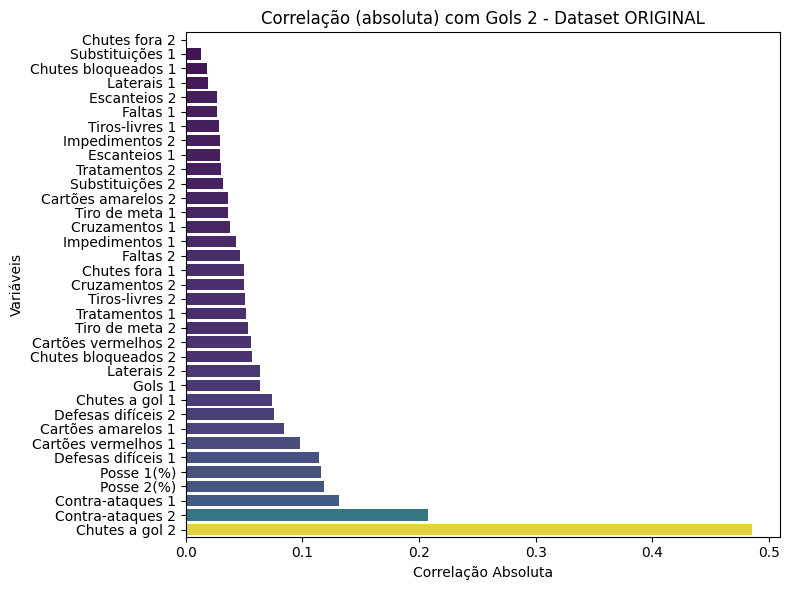

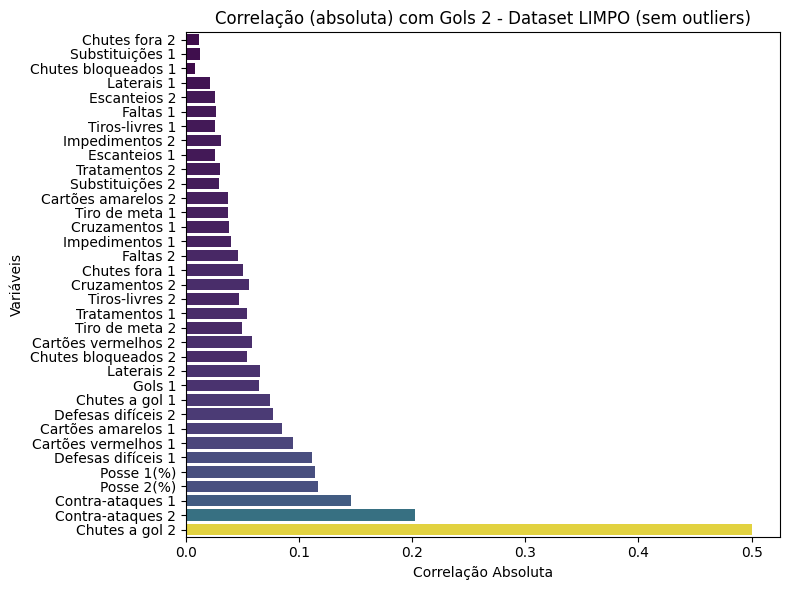

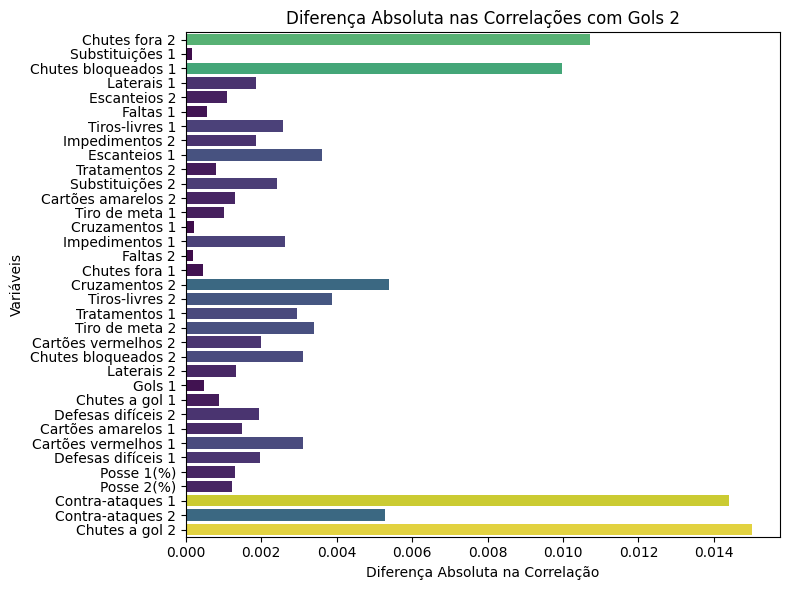

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lê os dados
df_original = pd.read_csv('entrada.csv')
df_limpo = pd.read_csv('saida_sem_outliers.csv')

# Remove colunas sem variância
df_valido_original = df_original.loc[:, df_original.nunique() > 1]
df_valido_limpo = df_limpo.loc[:, df_limpo.nunique() > 1]

# Filtra apenas colunas numéricas
df_numerico_original = df_valido_original.select_dtypes(include='number')
df_numerico_limpo = df_valido_limpo.select_dtypes(include='number')

# Calcula correlação
correlacao_original = df_numerico_original.corr(numeric_only=True)
correlacao_limpo = df_numerico_limpo.corr(numeric_only=True)

# Variável alvo
variavel_alvo = 'Gols 2'

# Filtra correlações com a variável alvo (exceto ela mesma)
correlacoes_original = correlacao_original[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()
correlacoes_limpo = correlacao_limpo[variavel_alvo].drop(labels=[variavel_alvo], errors='ignore').abs()

# Interseção de variáveis comuns
variaveis_comuns = correlacoes_original.index.intersection(correlacoes_limpo.index)
correlacoes_original = correlacoes_original.loc[variaveis_comuns]
correlacoes_limpo = correlacoes_limpo.loc[variaveis_comuns]

# Ordena conforme o dataset original (ordem base)
ordem_variaveis = correlacoes_original.sort_values().index

# Reordena os dados conforme o gráfico 1
correlacoes_original_ordenadas = correlacoes_original.loc[ordem_variaveis]
correlacoes_limpo_ordenadas = correlacoes_limpo.loc[ordem_variaveis]
diferencas_ordenadas = (correlacoes_limpo_ordenadas - correlacoes_original_ordenadas).abs()

# Função auxiliar para gerar cores com gradiente horizontal
def gerar_cores(valores, cmap_name='coolwarm'):
    norm = plt.Normalize(valores.min(), valores.max())
    cmap = plt.get_cmap(cmap_name)
    return [cmap(norm(v)) for v in valores]

# --- Plot 1: Dataset original ---
plt.figure(figsize=(8, 6))
cores1 = gerar_cores(correlacoes_original_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_original_ordenadas.values,
            y=correlacoes_original_ordenadas.index,
            palette=cores1)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset ORIGINAL')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 2: Dataset limpo ---
plt.figure(figsize=(8, 6))
cores2 = gerar_cores(correlacoes_limpo_ordenadas.values, cmap_name='viridis')
sns.barplot(x=correlacoes_limpo_ordenadas.values,
            y=correlacoes_limpo_ordenadas.index,
            palette=cores2)
plt.title(f'Correlação (absoluta) com {variavel_alvo} - Dataset LIMPO (sem outliers)')
plt.xlabel('Correlação Absoluta')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

# --- Plot 3: Diferença absoluta ---
plt.figure(figsize=(8, 6))
cores3 = gerar_cores(diferencas_ordenadas.values, cmap_name='viridis')
sns.barplot(x=diferencas_ordenadas.values,
            y=diferencas_ordenadas.index,
            palette=cores3)
plt.title(f'Diferença Absoluta nas Correlações com {variavel_alvo}')
plt.xlabel('Diferença Absoluta na Correlação')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

### Oque aprendemos?

- Tiros de meta vale a pena ser tratados (média correlação com gols)
- Substituições não valem a pena ser tratadas (baixa correlação com gols)
- Contra-ataques valem muito a pena (alta correlação com gols)

### Vamos ter uma análise mais abrangente!

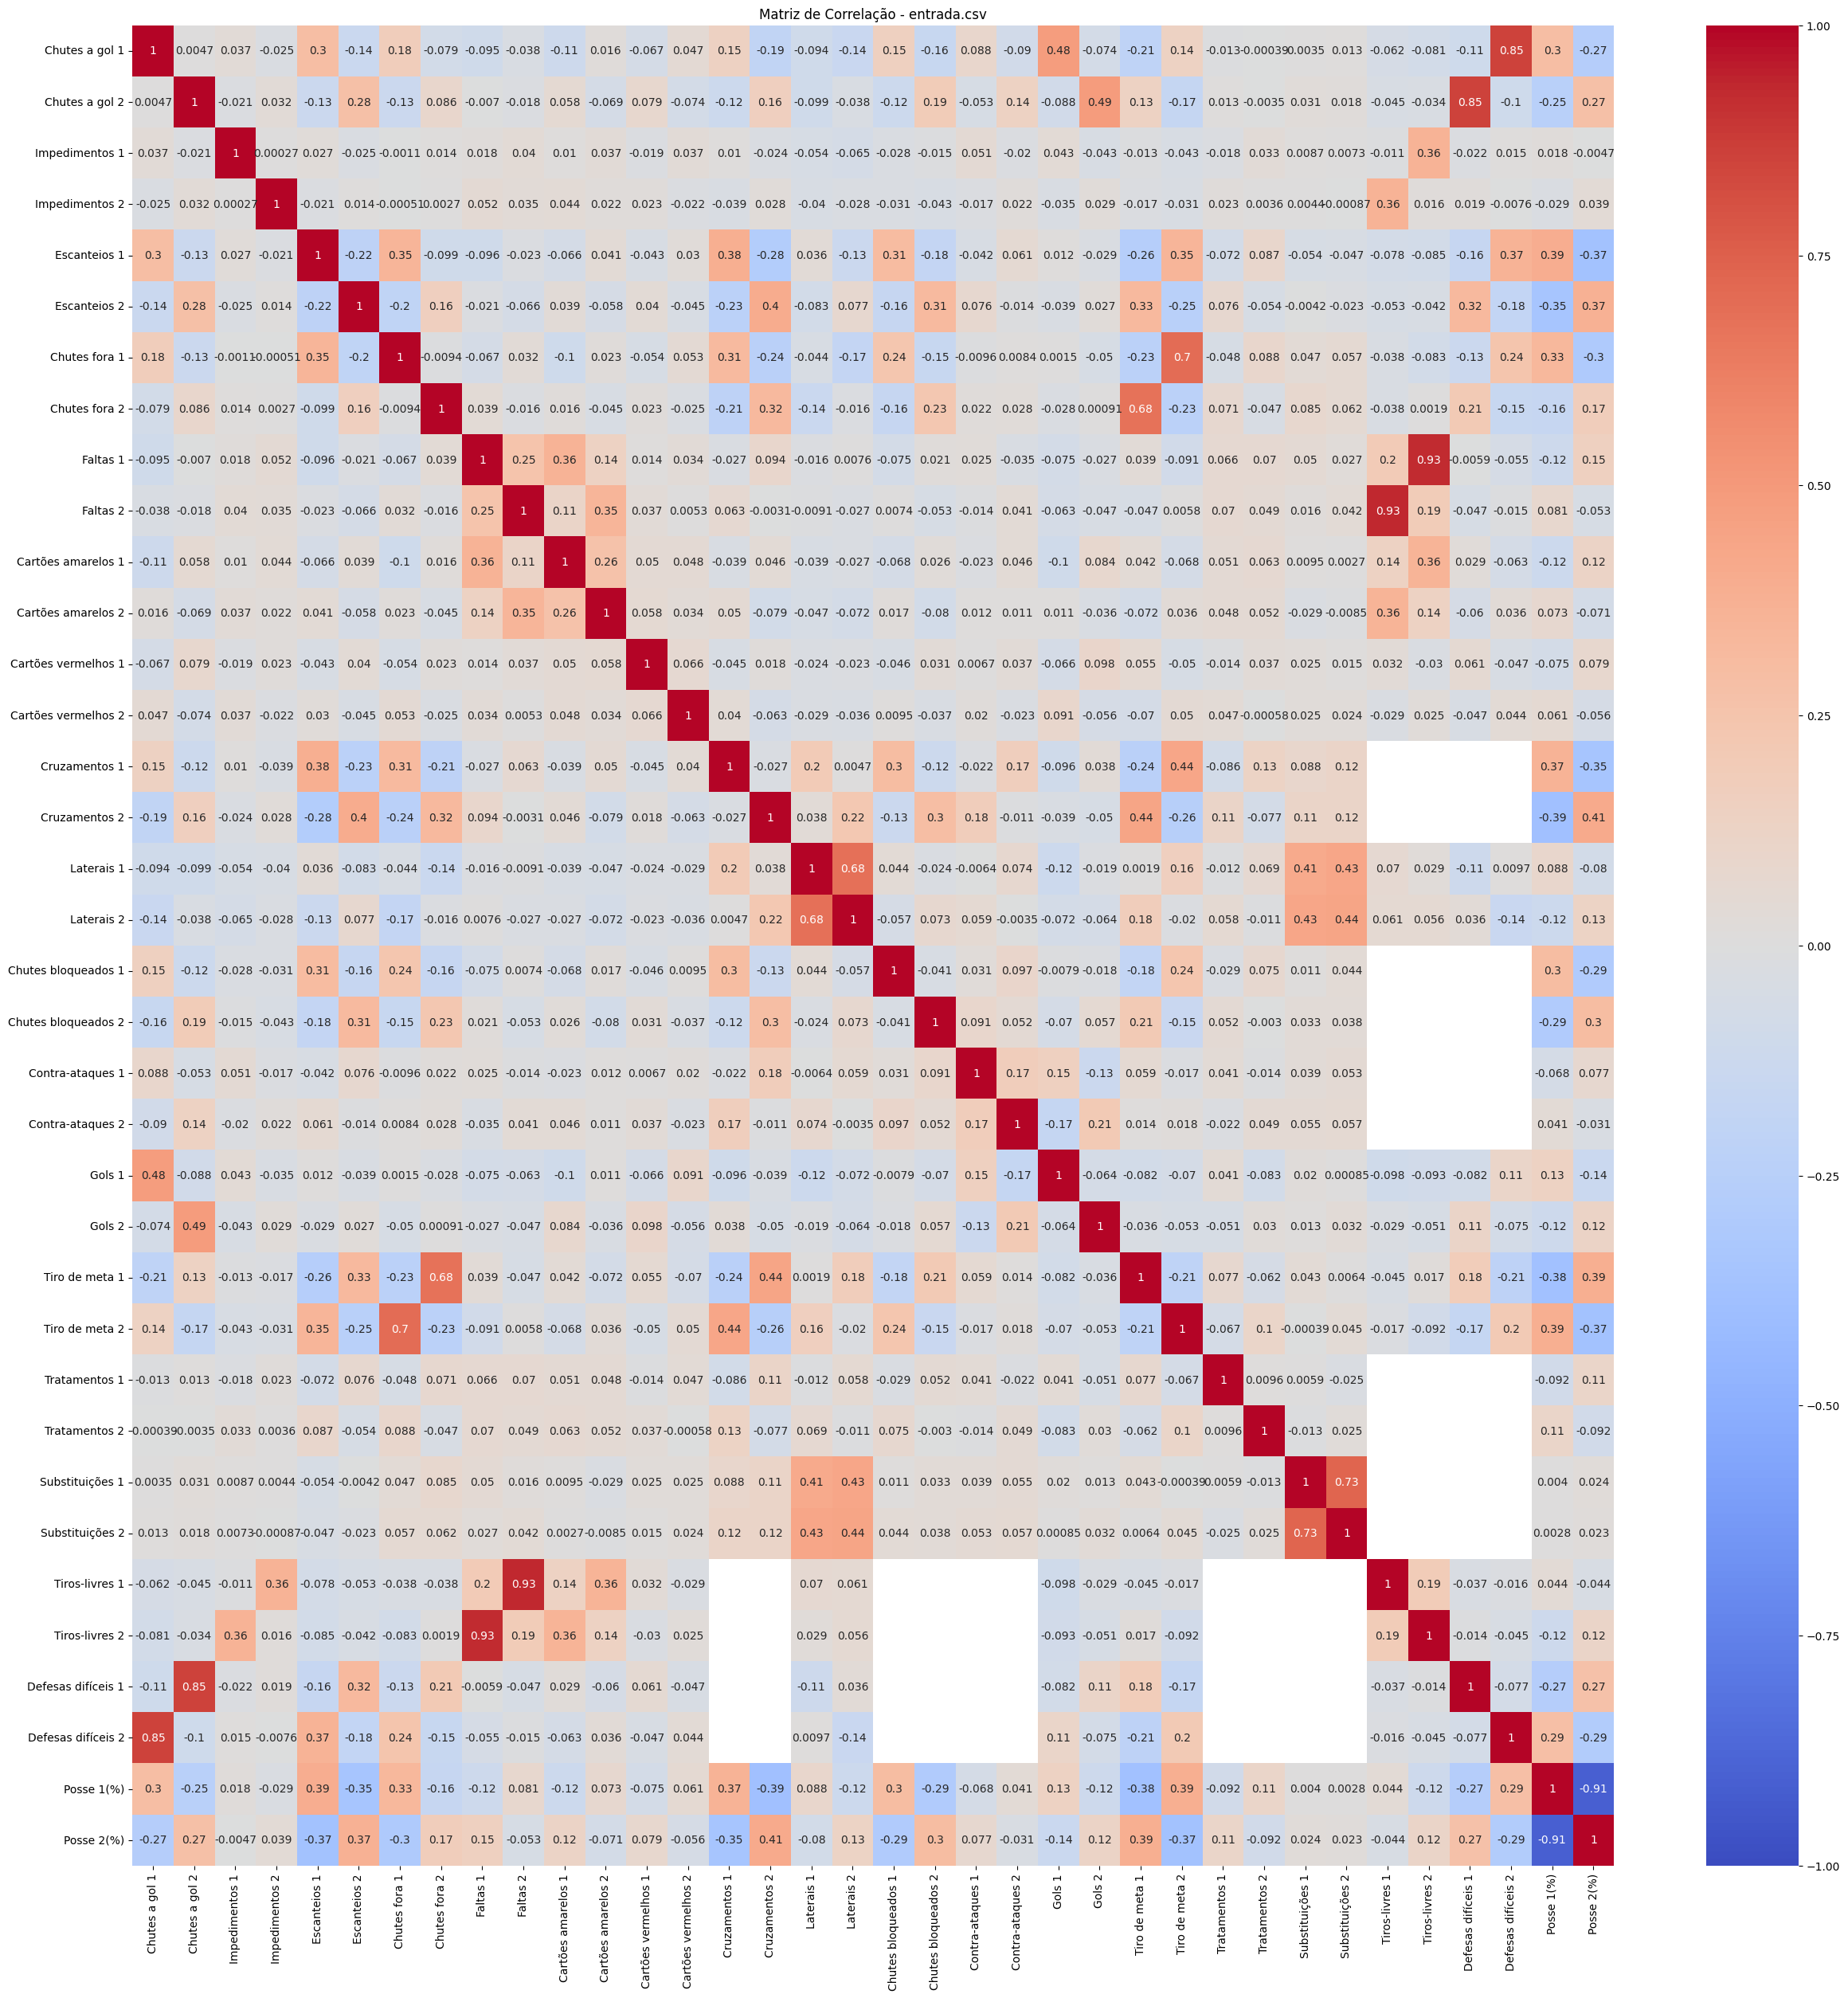

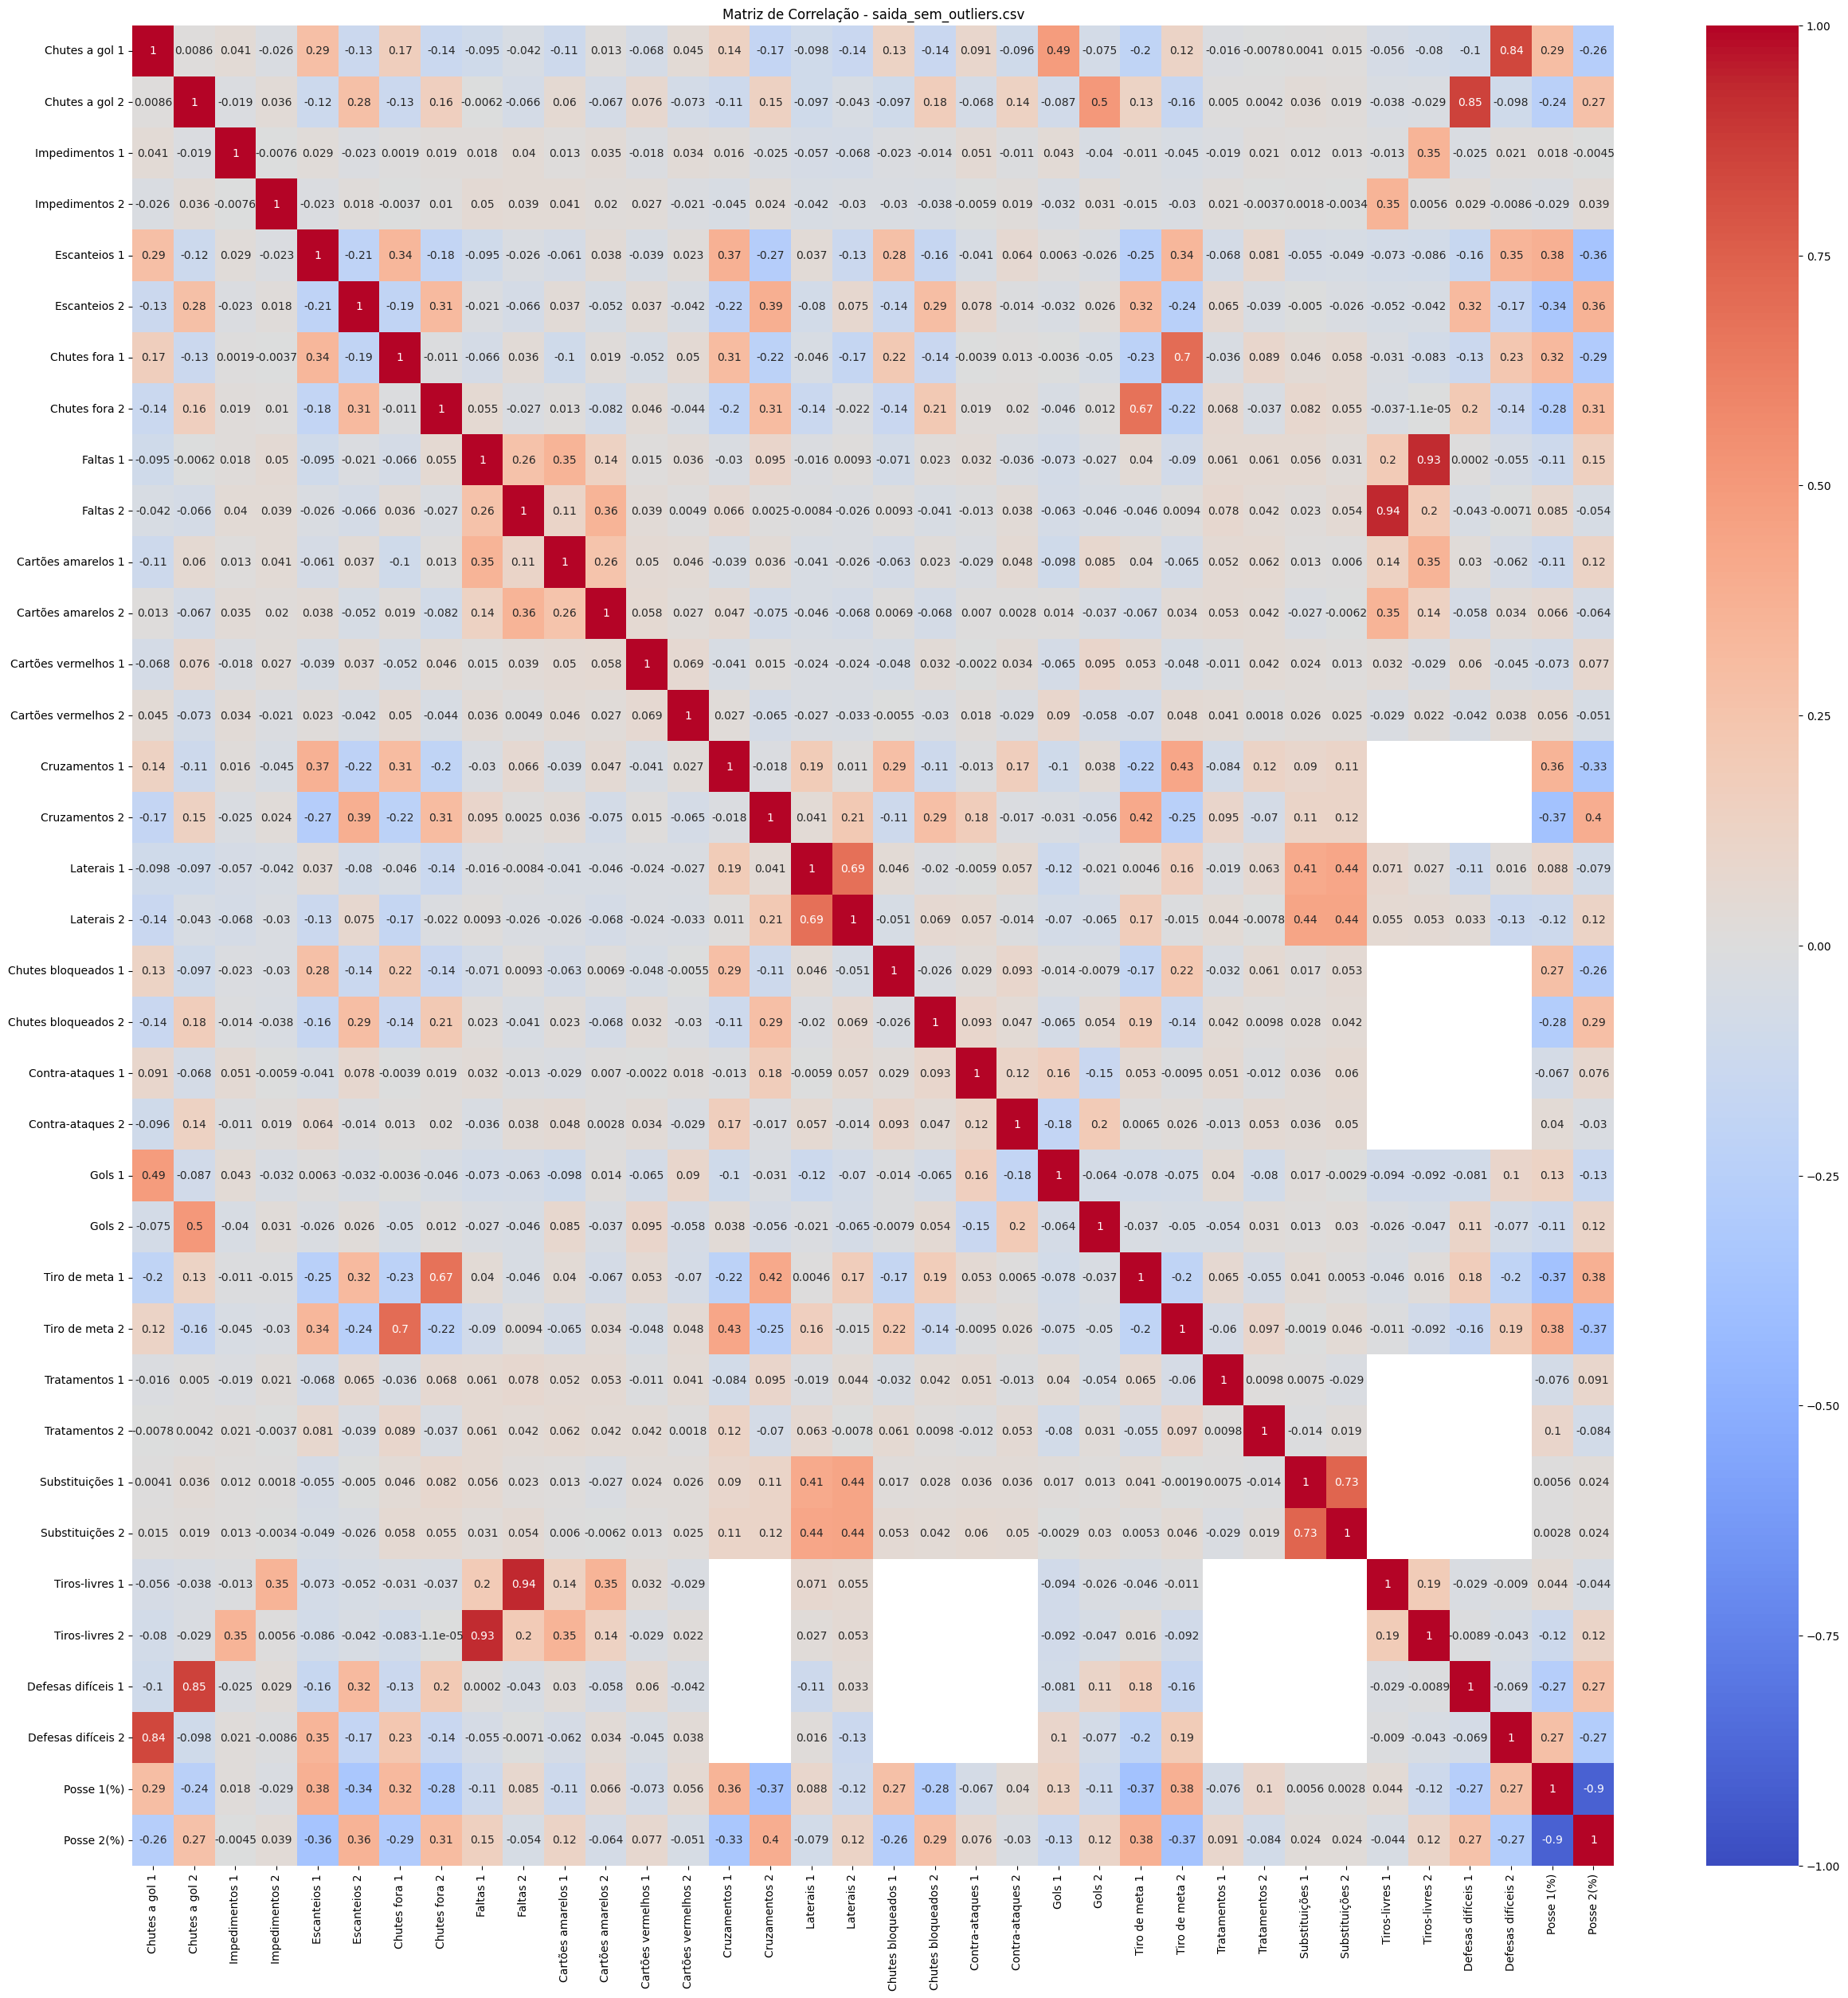

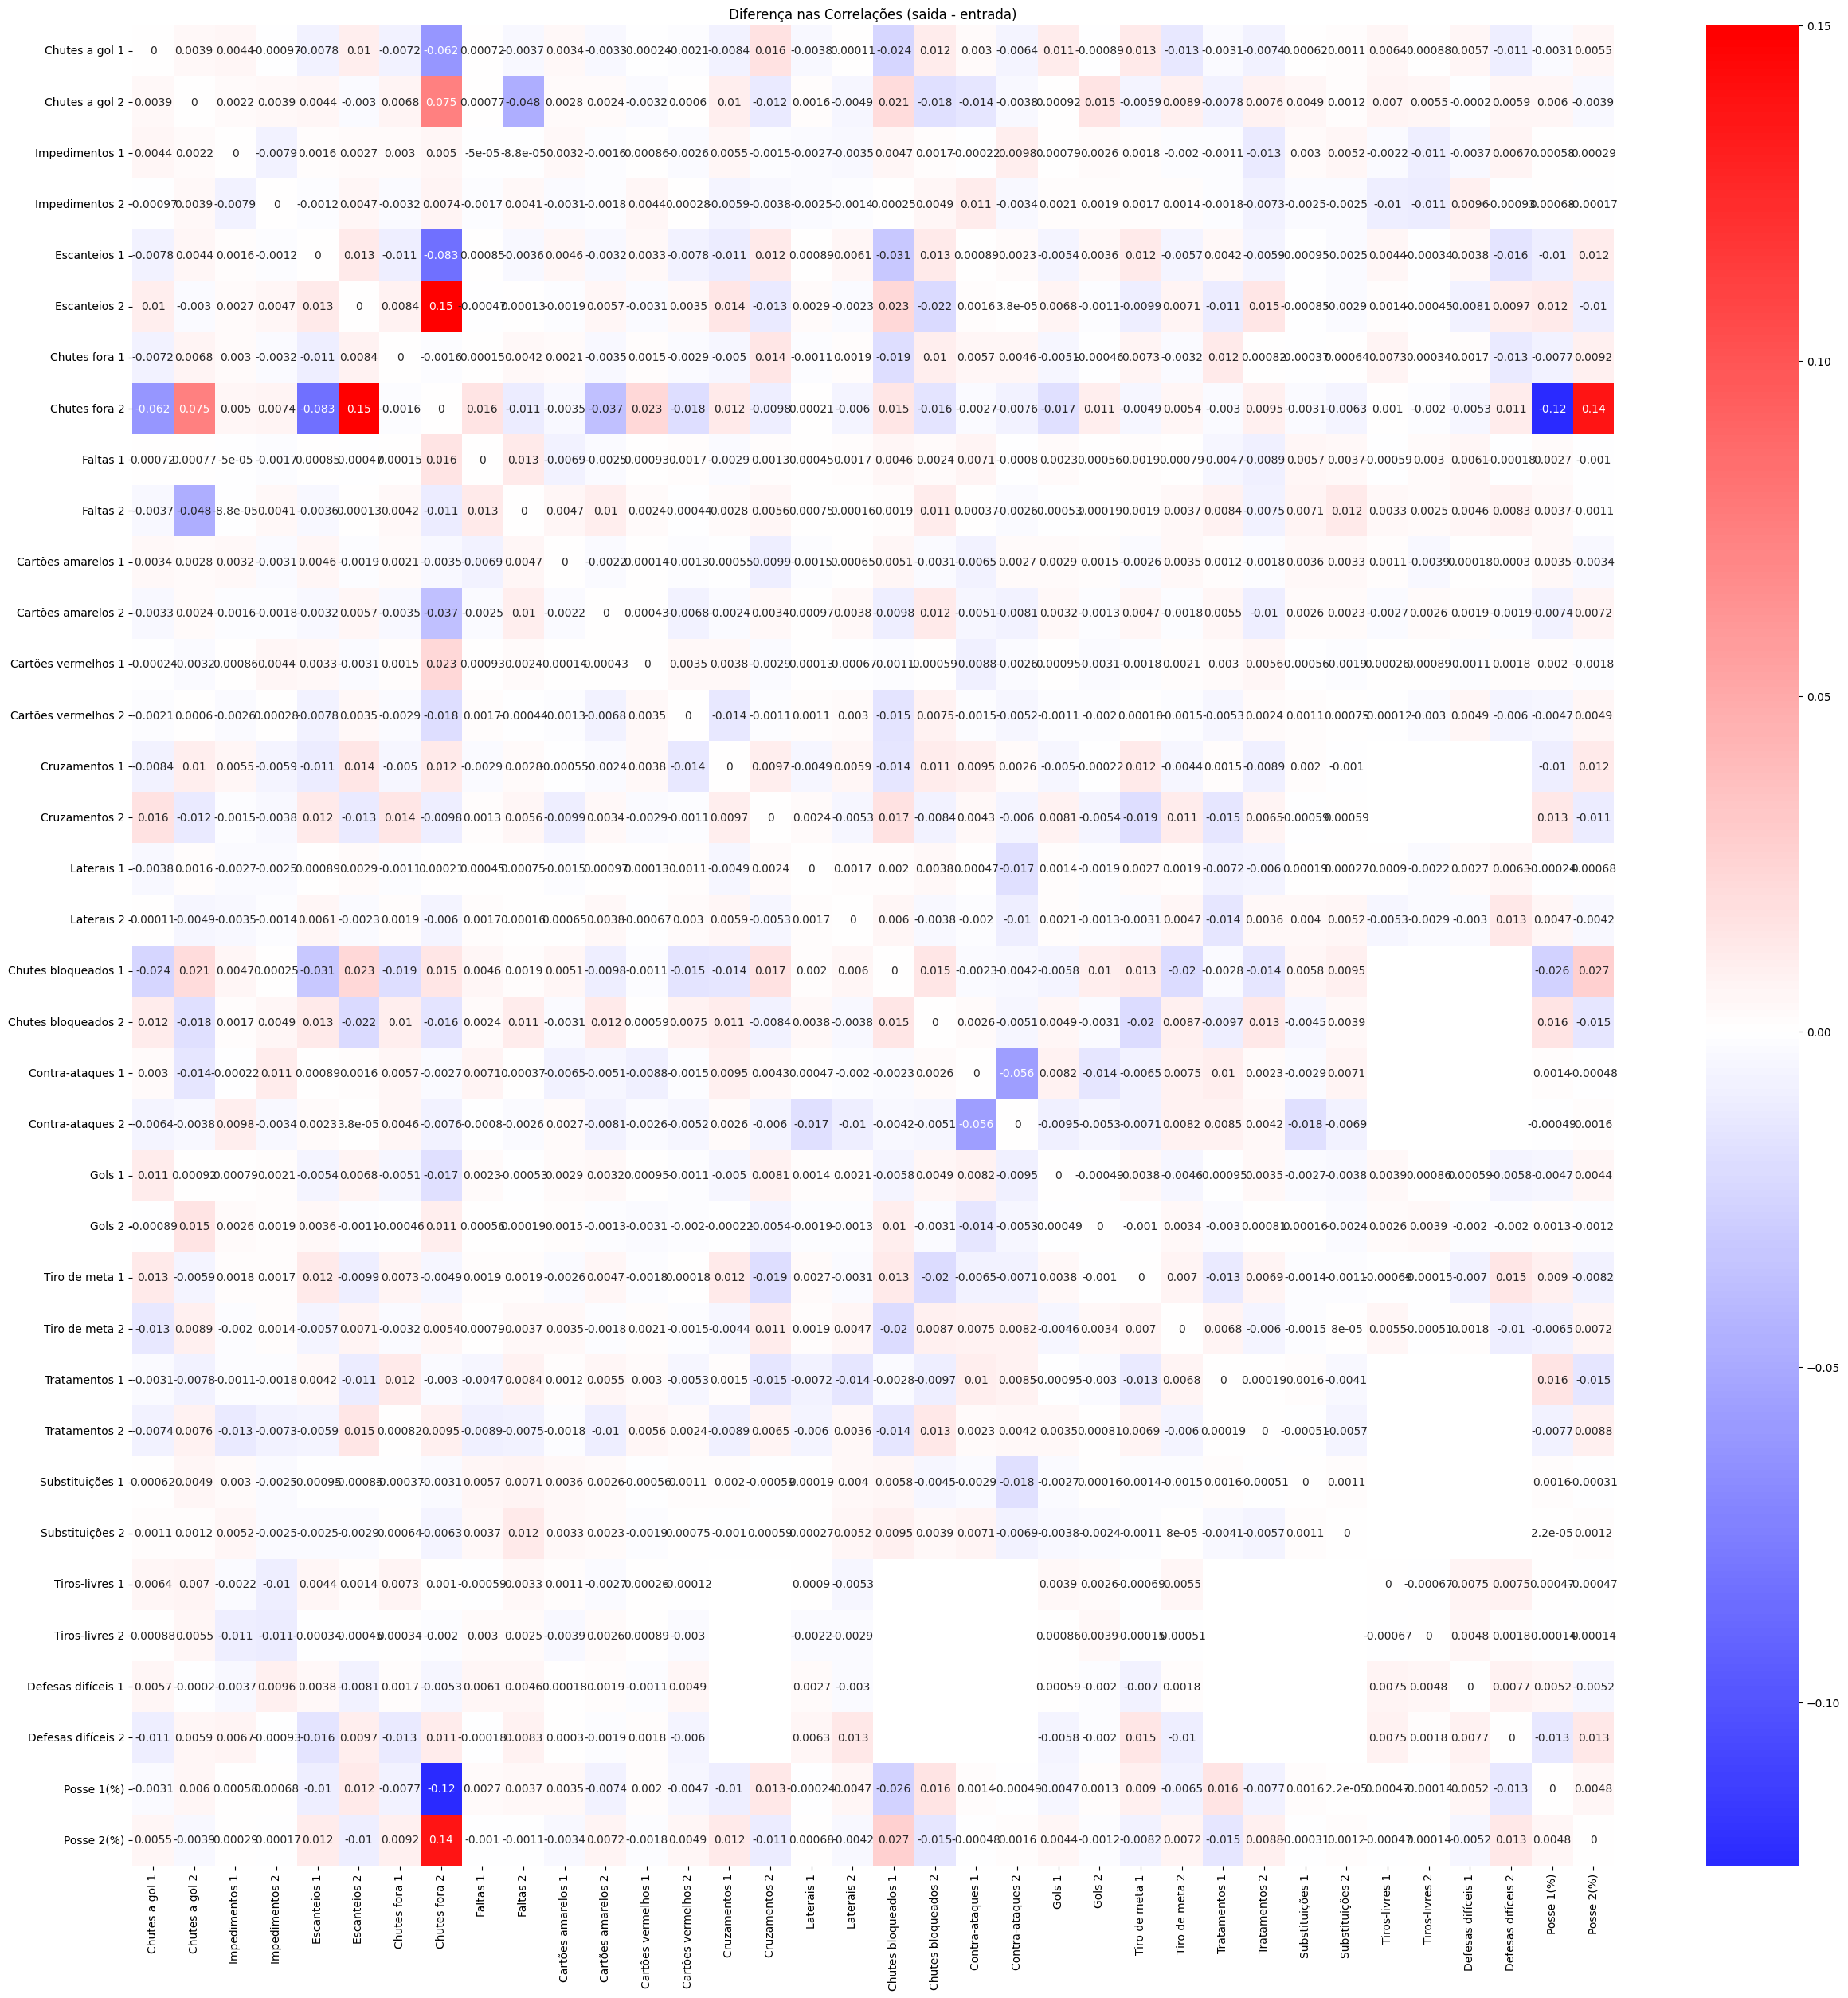

In [5]:
# Carrega os dados
df_entrada = pd.read_csv('entrada.csv')
df_saida = pd.read_csv('saida_sem_outliers.csv')

# Calcula as matrizes de correlação
correlacao_entrada = df_entrada.corr(numeric_only=True)
correlacao_saida = df_saida.corr(numeric_only=True)

# Calcula a diferença entre as correlações
correlacao_diferenca = correlacao_saida - correlacao_entrada

# Função para plotar heatmap
def plot_heatmap(correlacao, titulo):
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlacao, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(titulo)
    plt.show()

# Plot 1: Heatmap da correlação de entrada.csv
plot_heatmap(correlacao_entrada, "Matriz de Correlação - entrada.csv")

# Plot 2: Heatmap da correlação de saida_sem_outliers.csv
plot_heatmap(correlacao_saida, "Matriz de Correlação - saida_sem_outliers.csv")

# Plot 3: Heatmap da diferença entre as correlações
plt.figure(figsize=(30, 30))
sns.heatmap(correlacao_diferenca, annot=True, cmap='bwr', center=0)
plt.title("Diferença nas Correlações (saida - entrada)")
plt.show()